# Data Exploration & Feature Engineering

## Overview

In this section we will perform a first overview on wine dataset.
It's hard to know what to do if you don't know what you're working with, so let's load our dataset and take a peek. We will try to figure out the dataset size, number of features and the column types (features + target).

In [1]:
import numpy as np
import pandas as pd
from time import time

%matplotlib inline

# Read student data
data = pd.read_csv("data.csv", delimiter=";")
print("Data read successfully!")

# Calculate number of wines in dataset
n_wines = data.shape[0]

# Calculate number of features
n_features = data.shape[1] - 1

# Print the results
display(data.head())

print("Total number of wines: {}".format(n_wines))
print("Number of features: {}".format(n_features))


Data read successfully!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Total number of wines: 6497
Number of features: 12


**Attribute types**:

We have the following column types in the dataset:
  - `type`: Categorical (nominal)
  - `fixed acidity`: Numeric (continuous)
  - `volatile acidity`: Numeric (continuous)
  - `citric acid`: Numeric (continuous)
  - `residual sugar`: Numeric (continuous)
  - `chlorides`: Numeric (continuous)
  - `free sulfur dioxide`: Numeric (continuous)
  - `total sulfur dioxide`: Numeric (continuous)
  - `density`: Numeric (continuous)
  - `pH`: Numeric (continuous)
  - `sulphates`: Numeric (continuous)
  - `alcohol`: Numeric (continuous)
  - `quality`: Numeric (ordinal)



# Preparing data

In this section, we will prepare the data for modeling, training and testing.

## Feature columns vs target column

It is often the case that the data contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

The code cell below will separate the wine data into feature and target columns to see if any features are non-numeric.

In [2]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'quality'
target_col = data.columns[-1]

# Show the list of columns
print("\nTarget column: {}".format(target_col))

print("\nFeature types:")
print(data[feature_cols].dtypes)

print("\nTarget type:")
print(data[target_col].dtypes)

print("\nClasses from `type` feature:")
print(data['type'].unique())


Target column: quality

Feature types:
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
dtype: object

Target type:
int64

Classes from `type` feature:
['White' 'Red']


## Preprocess features

As we can see, there two non-numeric features that need to be converted: `type` and `alcohol`.

The `type` feature only has two classes (`['White' 'Red']`), so it can be reasonably converted into 1/0 (binary) values.

The `alcohol` feature is actually a numeric feature, but some rows are wrong non-numeric values, for example `'110.666.666.666.667'`, `'956.666.666.666.667'`, `'923.333.333.333.333'` and so on. Therefore, we will parse the values of this feature into numeric values and replace the wrong values with the mean of all of the values for the feature ([reference](https://machinelearningmastery.com/handle-missing-data-python/)).

The code cell below performs the preprocessing routine discussed.
 


In [3]:

def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables into
        binary (0/1) variables.'''

    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If type, replace all 'White'/'Red' values with 1/0
        if col == 'type' and col_data.dtype == object:
            col_data = col_data.replace(['White', 'Red'], [1, 0])
        
        # If alcohol, parse it values to numberic and coerce the convertion errors
        if col == 'alcohol' and col_data.dtype == object:
            col_data = pd.to_numeric(col_data, errors='coerce')

        # Collect the revised columns
        output = output.join(col_data)

    # handle NaN values by inputting the mean
    output.fillna(output.mean(), inplace=True)
    
    return output

data = preprocess_features(data)

## Outliers and Feature scaling

We've successfully cleaned our data and converted it into a form which is easily consumable by machine learning algorithms. However, at this point we should consider whether or not some method of data normalization / scaling or outlier removal will be beneficial for our algorithm.

Feature normalization / scaling allows for all features to contribute equally (or more aptly, it allows for features to contribute relative to their importance rather than their scale).

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample. Some machine learning are sensitive to outliers.

The code cell below plots the boxplot for all features in dataset.

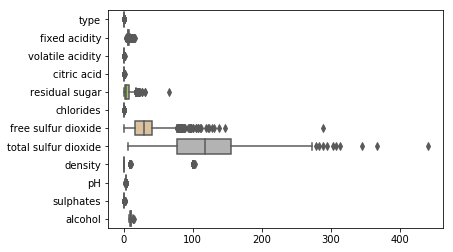

In [4]:
import seaborn as sns
sns.boxplot(data=data[feature_cols], orient="h", palette="Set2")

As we can see, the features contain many (extreme) outliers. In the code cell bellow we will create a function to  perform outlier removal based on boxplot method and IQR factor (default == 1.5) ([reference](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)). In a later section, we will vary this factor to analyse the best threshold to remove the outliers.

In [5]:
def remove_outliers(data_orig, feature_cols, target_col, factor=1.5, verbose=False):
    data = data_orig.copy()
    features = feature_cols
    Q1 = data[features].quantile(0.25)
    Q3 = data[features].quantile(0.75)
    IQR = Q3 - Q1    
    is_outlier = (data[features] < (Q1 - factor * IQR)) |(data[features] > (Q3 + factor * IQR))
    data = data[~(is_outlier).any(axis=1)]
    if verbose:
        print("Number of outliers for IQR factor {}: {}".format(factor, data_orig.shape[0] - data.shape[0]))
    return data[feature_cols], data[target_col]

test1 = remove_outliers(data, feature_cols, target_col, verbose=True)
test1 = remove_outliers(data, feature_cols, target_col, factor=3.5, verbose=True)

Number of outliers for IQR factor 1.5: 2192
Number of outliers for IQR factor 3.5: 1737
type                      int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object int64
<class 'tuple'>
<class 'pandas.core.series.Series'> <class 'numpy.dtype'>


In the boxplot, the range of values varies widely between the features. We will create a function to normalize features using min-max or standard methods so that each feature contributes proportionately in the same scale in the models.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(X, scaler_type='minmax'):
    X = X.copy() # TODO
    scaler = MinMaxScaler()
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()

    features = list(X.select_dtypes(include=['float64']).columns)
    X[features] = scaler.fit_transform(X[features])
    return X


## Data balancing

A very frequent problem in machine learning models is imbalanced dataset, because an imbalanced dataset may lead to inflated performance estimates ([reference](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data)). Therefore, We will analyse if the dataset response variable is balalanced or not.

Bar plot for the counts of observations in each quality class.
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


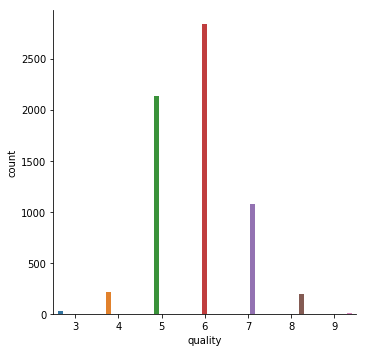

In [7]:
print("Bar plot for the counts of observations in each quality class.")
sns.catplot("quality", data=data, hue='quality', kind="count")
print(data[target_col].value_counts())

As we can see, the response variable `quality` is very unbalanced. The code cell bellow will balance the minority classes by up-sample them. Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal ([reference](https://elitedatascience.com/imbalanced-classes)).

Bar plot for the counts in each quality class after data balance.
9    2836
8    2836
7    2836
6    2836
5    2836
4    2836
3    2836
Name: quality, dtype: int64
Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')
type                      int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


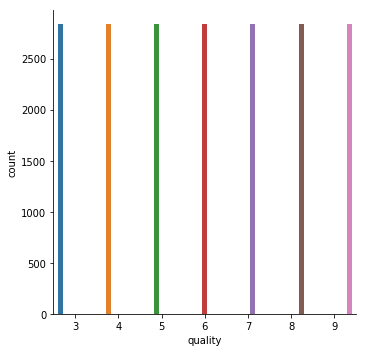

In [8]:
from sklearn.utils import resample

def upsample(data, target_col, majority_class):
    '''
    Upsample minority class based on majority_class size of a give target column
    '''
    target_classes = data[target_col].unique()
    majoritary_df = data[data[target_col] == majority_class]
    majoritary_size = majoritary_df.shape[0]
    frames = [majoritary_df]

    # combine majority class data frame with upsampled minority ones
    for target_class in target_classes:
        if target_class == majority_class:
            continue
        df = data[data[target_col] == target_class]
        df_upsampled = resample(df, replace=True, n_samples=majoritary_size, random_state=123)
        frames.append(df_upsampled)
    data_balanced = pd.concat(frames)
    return data_balanced

target_majority_class = 6
data_balanced = upsample(data, target_col, target_majority_class)

print("Bar plot for the counts in each quality class after data balance.")
sns.catplot("quality", data=data_balanced, hue='quality', kind="count")
print(data_balanced[target_col].value_counts())

# Model Training and Evaluation
With the predefined functions above, we will now import the three supervised learning models to train and  perform the cross validation for each one. We will train each classifier for four different training set sizes (25%, 50%, 75% and 100%) and two different normalizaton methods (min-max, standard). We will also remove the outliers from the training set based on different IQR factors (1.5, 2.0, 2.5, 3.0, 3.5, 4.0) to train each classifier.

In [14]:
from sklearn.model_selection import cross_val_score

# http://scikit-learn.org/stable/modules/multiclass.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def cross_validation(classifier, X, y, cv=10, size_proportions=[0.25, 0.50, 0.75, 1.0]):
    '''
    Execute the 'cross_val_score' function for a classifier, each 
    training set size proportion (25%, 50%, 75%, 100%), and each
    normalization type (min-max, standard)
    '''
    scores = []
    total_size = X.shape[0]
    sizes = (map(lambda p: int(total_size * p), size_proportions))
    X_minmax = scale(X, scaler_type='minmax')
    X_standard = scale(X, scaler_type='standard')

    for size in sizes:
        scores1 = cross_val_score(classifier, X[:size], y[:size], cv=cv)
        scores2 = cross_val_score(classifier, X_minmax[:size], y[:size], cv=cv)
        scores3 = cross_val_score(classifier, X_standard[:size], y[:size], cv=cv)
        scores.append([size, np.mean(scores1), np.mean(scores2), np.mean(scores3)])
    result = pd.DataFrame(scores, columns=['size(X)', 'X', 'minmax(X)', 'standard(X)'])
    return result

# Initialize the models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = RandomForestClassifier(n_estimators=100)
clf_C = LinearDiscriminantAnalysis()

classifiers = [clf_A, clf_B, clf_C]
iqr_factors = [1.5, 2.0, 2.5, 3.0, 3.5]
size_proportions=[0.25, 0.50, 0.75, 1.0]
cv_k_fold = 7

# Execute the 'cross_validation' function for each classifier, iqr_factor and training set size proportions
for clf in classifiers:
    print("\n[{}]\n".format(clf.__class__.__name__))

    print('Scores considering outliers')
    X_all, y_all = data_balanced[feature_cols], data_balanced[target_col]
    scores = cross_validation(clf, X_all, y_all, cv=k_fold)
    display(scores)

    for iqr_factor in iqr_factors:
        print('Scores considering no outliers, IQR factor', iqr_factor)
        X_all, y_all = remove_outliers(data_balanced, feature_cols, target_col, factor=iqr_factor)
        scores = cross_validation(clf, X_all, y_all, cv=cv_k_fold)
        display(scores)




# TODO sklearn.ensemble.GradientBoostingClassifier
# http://scikit-learn.org/stable/modules/model_evaluation.html
# https://elitedatascience.com/imbalanced-classes
# https://stackoverflow.com/questions/26210471/scikit-learn-gridsearch-giving-valueerror-multiclass-format-is-not-supported
#     print(y.unique())
#     y = label_binarize(y, classes=y.unique())
#     print(y)


[DecisionTreeClassifier]

Scores considering outliers


,size(X),X,minmax(X),standard(X)
0,4963,0.703377,0.703381,0.703778
1,9926,0.787223,0.787427,0.787323
2,14889,0.849893,0.848884,0.849691
3,19852,0.890038,0.887568,0.889584


Scores considering no outliers, IQR factor 1.5


,size(X),X,minmax(X),standard(X)
0,3373,0.767299,0.766703,0.766411
1,6746,0.805219,0.806107,0.806107
2,10119,0.870450,0.869758,0.870946
3,13493,0.904328,0.905069,0.904551


Scores considering no outliers, IQR factor 2.0


,size(X),X,minmax(X),standard(X)
0,3604,0.764450,0.765838,0.766115
1,7208,0.792601,0.793849,0.792602
2,10812,0.866263,0.867003,0.865892
3,14416,0.893526,0.893734,0.893457


Scores considering no outliers, IQR factor 2.5


,size(X),X,minmax(X),standard(X)
0,3698,0.756121,0.757474,0.758556
1,7396,0.792058,0.791789,0.792059
2,11094,0.867054,0.866603,0.866874
3,14793,0.897451,0.897587,0.897587


Scores considering no outliers, IQR factor 3.0


,size(X),X,minmax(X),standard(X)
0,3718,0.745839,0.744763,0.746377
1,7437,0.797642,0.798449,0.796836
2,11155,0.865809,0.866346,0.866436
3,14874,0.898818,0.898953,0.899491


Scores considering no outliers, IQR factor 3.5


,size(X),X,minmax(X),standard(X)
0,3777,0.758317,0.758315,0.757523
1,7555,0.806095,0.806359,0.807021
2,11332,0.863935,0.864289,0.863494
3,15110,0.899076,0.899209,0.899340


Scores considering no outliers, IQR factor 4.0


,size(X),X,minmax(X),standard(X)
0,3811,0.765958,0.767271,0.766747
1,7622,0.803337,0.803863,0.803732
2,11433,0.867498,0.868022,0.867847
3,15245,0.897937,0.897806,0.898265



[RandomForestClassifier]

Scores considering outliers


,size(X),X,minmax(X),standard(X)
0,4963,0.739024,0.744871,0.739425
1,9926,0.804136,0.802925,0.802424
2,14889,0.865334,0.867283,0.866005
3,19852,0.899555,0.901166,0.901718


Scores considering no outliers, IQR factor 1.5


,size(X),X,minmax(X),standard(X)
0,3373,0.830501,0.829324,0.834062
1,6746,0.841843,0.840657,0.838290
2,10119,0.897033,0.895848,0.896536
3,13493,0.922559,0.924338,0.921148


Scores considering no outliers, IQR factor 2.0


,size(X),X,minmax(X),standard(X)
0,3604,0.814145,0.814690,0.814972
1,7208,0.841014,0.837549,0.840046
2,10812,0.888554,0.892255,0.889386
3,14416,0.919609,0.919120,0.920787


Scores considering no outliers, IQR factor 2.5


,size(X),X,minmax(X),standard(X)
0,3698,0.814558,0.812935,0.811312
1,7396,0.843030,0.838435,0.839107
2,11094,0.894002,0.890307,0.890941
3,14793,0.920169,0.918953,0.920844


Scores considering no outliers, IQR factor 3.0


,size(X),X,minmax(X),standard(X)
0,3718,0.816586,0.818741,0.813359
1,7437,0.839998,0.841208,0.840535
2,11155,0.891445,0.892073,0.889834
3,14874,0.918990,0.922621,0.919931


Scores considering no outliers, IQR factor 3.5


,size(X),X,minmax(X),standard(X)
0,3777,0.816320,0.813395,0.815528
1,7555,0.841710,0.841705,0.838131
2,11332,0.894375,0.894465,0.893228
3,15110,0.919925,0.921975,0.919727


Scores considering no outliers, IQR factor 4.0


,size(X),X,minmax(X),standard(X)
0,3811,0.817419,0.817417,0.813744
1,7622,0.844935,0.847301,0.842708
2,11433,0.891286,0.892689,0.893121
3,15245,0.922078,0.920307,0.921553



[LinearDiscriminantAnalysis]

Scores considering outliers


,size(X),X,minmax(X),standard(X)
0,4963,0.650983,0.650983,0.650983
1,9926,0.464915,0.464915,0.464915
2,14889,0.404449,0.404449,0.404449
3,19852,0.446450,0.446450,0.446450


Scores considering no outliers, IQR factor 1.5


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

,size(X),X,minmax(X),standard(X)
0,3373,0.683496,0.683496,0.683496
1,6746,0.455660,0.455660,0.455660
2,10119,0.415154,0.415154,0.415154
3,13493,0.492997,0.492997,0.492997


Scores considering no outliers, IQR factor 2.0


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

,size(X),X,minmax(X),standard(X)
0,3604,0.671239,0.671239,0.671239
1,7208,0.459477,0.459477,0.459477
2,10812,0.416104,0.416104,0.416104
3,14416,0.485709,0.485709,0.485709


Scores considering no outliers, IQR factor 2.5


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,size(X),X,minmax(X),standard(X)
0,3698,0.672320,0.672320,0.672320
1,7396,0.458879,0.458879,0.458879
2,11094,0.413812,0.413812,0.413812
3,14793,0.474678,0.474678,0.474678


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Scores considering no outliers, IQR factor 3.0


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

,size(X),X,minmax(X),standard(X)
0,3718,0.674572,0.674572,0.674572
1,7437,0.464287,0.464287,0.464287
2,11155,0.421598,0.421598,0.421598
3,14874,0.475256,0.475256,0.475256


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Scores considering no outliers, IQR factor 3.5


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

,size(X),X,minmax(X),standard(X)
0,3777,0.676265,0.676265,0.676265
1,7555,0.456238,0.456238,0.456238
2,11332,0.420307,0.420307,0.420307
3,15110,0.470748,0.470748,0.470748


Scores considering no outliers, IQR factor 4.0


/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernando/Workspace/cognitive.ai/wine-test/.env/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinea

,size(X),X,minmax(X),standard(X)
0,3811,0.672587,0.672587,0.672587
1,7622,0.457080,0.457080,0.457080
2,11433,0.411692,0.411692,0.411692
3,15245,0.461135,0.461135,0.461135
